In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sn
import pandas.plotting
import scipy.stats

In [2]:
train_data = pd.read_csv('train.csv')
train_data.datetime = pd.to_datetime(train_data.datetime)
train_data['hour'] = train_data.datetime.dt.hour
train_data['month'] = train_data.datetime.dt.month
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
hour          10886 non-null int64
month         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(10)
memory usage: 1.2 MB


In [3]:
categorical_features = ['season', 'holiday', 'month', 'hour', 'workingday', 'weather']
number_features = ['temp', 'atemp', 'humidity', 'windspeed']
target_feature = ['count']

In [4]:
train_data[categorical_features].astype('category').describe()

,season,holiday,month,hour,workingday,weather
count,10886,10886,10886,10886,10886,10886
unique,4,2,12,24,2,4
top,4,0,12,23,1,1
freq,2734,10575,912,456,7412,7192


In [5]:
train_data[number_features].describe()

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


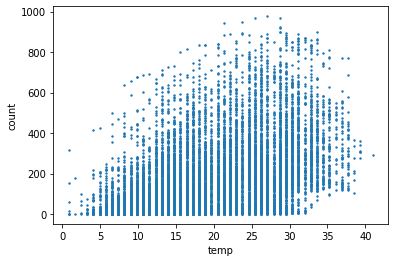

In [6]:
train_data.plot.scatter('temp','count',s=2)

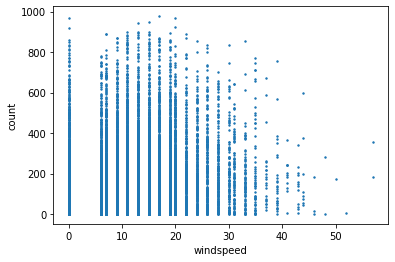

In [7]:
train_data.plot.scatter('windspeed','count',s=2)

In [8]:
weekday_list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
train_data['dayofweek'] = pd.Categorical(train_data['datetime'].dt.weekday_name,
                                       ordered=True,
                                       categories=weekday_list)

In [9]:
countday_list = []
for x in weekday_list:
    countday_list.append(train_data[train_data.dayofweek == x]['count'].sum())
countday_list

[295296, 291985, 292226, 306401, 302504, 311518, 285546]

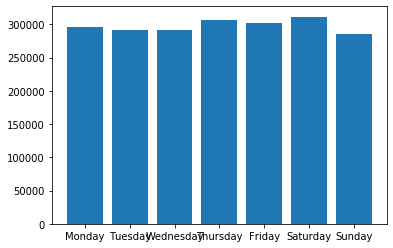

In [10]:
plt.bar(weekday_list, countday_list)
plt.show()

In [11]:
train_data['timeofday'] = train_data['datetime'].dt.hour + train_data['datetime'].dt.minute / 60

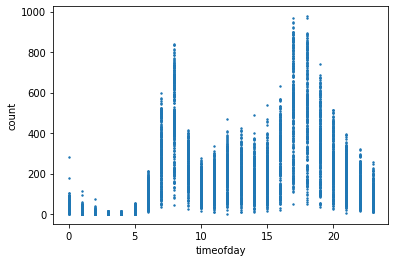

In [12]:
train_data[train_data.workingday == 1].plot.scatter('timeofday','count',s=2)

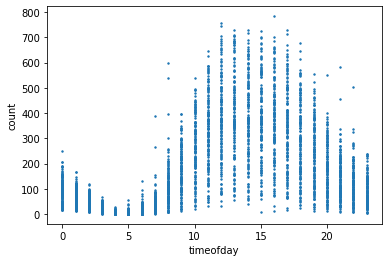

In [13]:
train_data[train_data.workingday == 0].plot.scatter('timeofday','count',s=2)

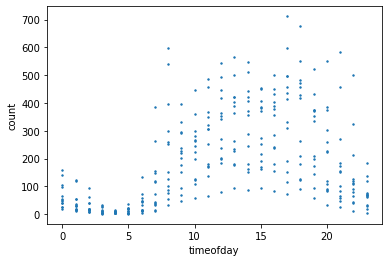

In [14]:
train_data[train_data.holiday == 1].plot.scatter('timeofday','count',s=2)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


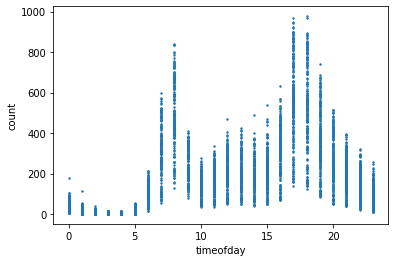

In [15]:
train_data[train_data.weather == 1][train_data.workingday == 1].plot.scatter('timeofday', 'count', s=2)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


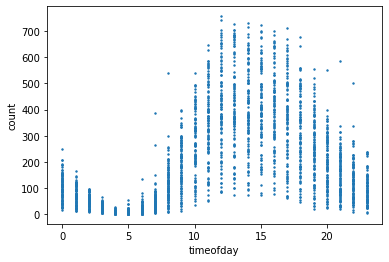

In [16]:
train_data[train_data.weather == 1][train_data.workingday == 0].plot.scatter('timeofday', 'count', s=2)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


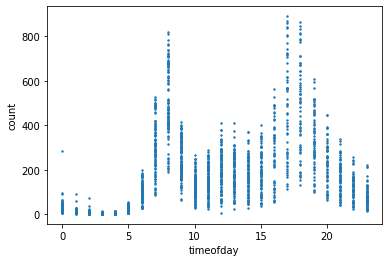

In [17]:
train_data[train_data.weather == 2][train_data.workingday == 1].plot.scatter('timeofday', 'count', s=2)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


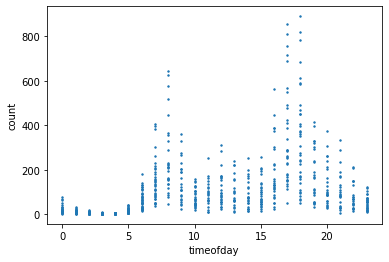

In [18]:
train_data[train_data.weather == 3][train_data.workingday == 1].plot.scatter('timeofday', 'count', s=2)

In [19]:
train_data.loc[:,['dayofweek', 'workingday', 'holiday']]

,dayofweek,workingday,holiday
0,Saturday,0,0
1,Saturday,0,0
2,Saturday,0,0
3,Saturday,0,0
4,Saturday,0,0
...,...,...,...
10881,Wednesday,1,0
10882,Wednesday,1,0
10883,Wednesday,1,0
10884,Wednesday,1,0


In [20]:
train_data.to_csv('check.csv')

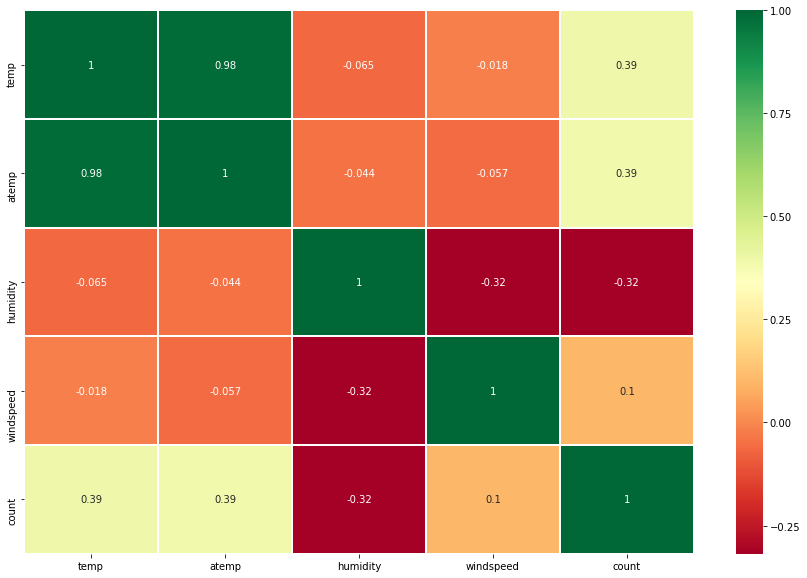

In [21]:
fig, ax = plt.subplots(figsize=(15,10)) 
sn.heatmap(train_data[number_features + target_feature].corr(), linewidths=1, annot=True, cmap="RdYlGn", ax=ax)
plt.show()

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Wind Speed'),
 Text(0.5, 1.0, 'Count Over Wind Speeds')]

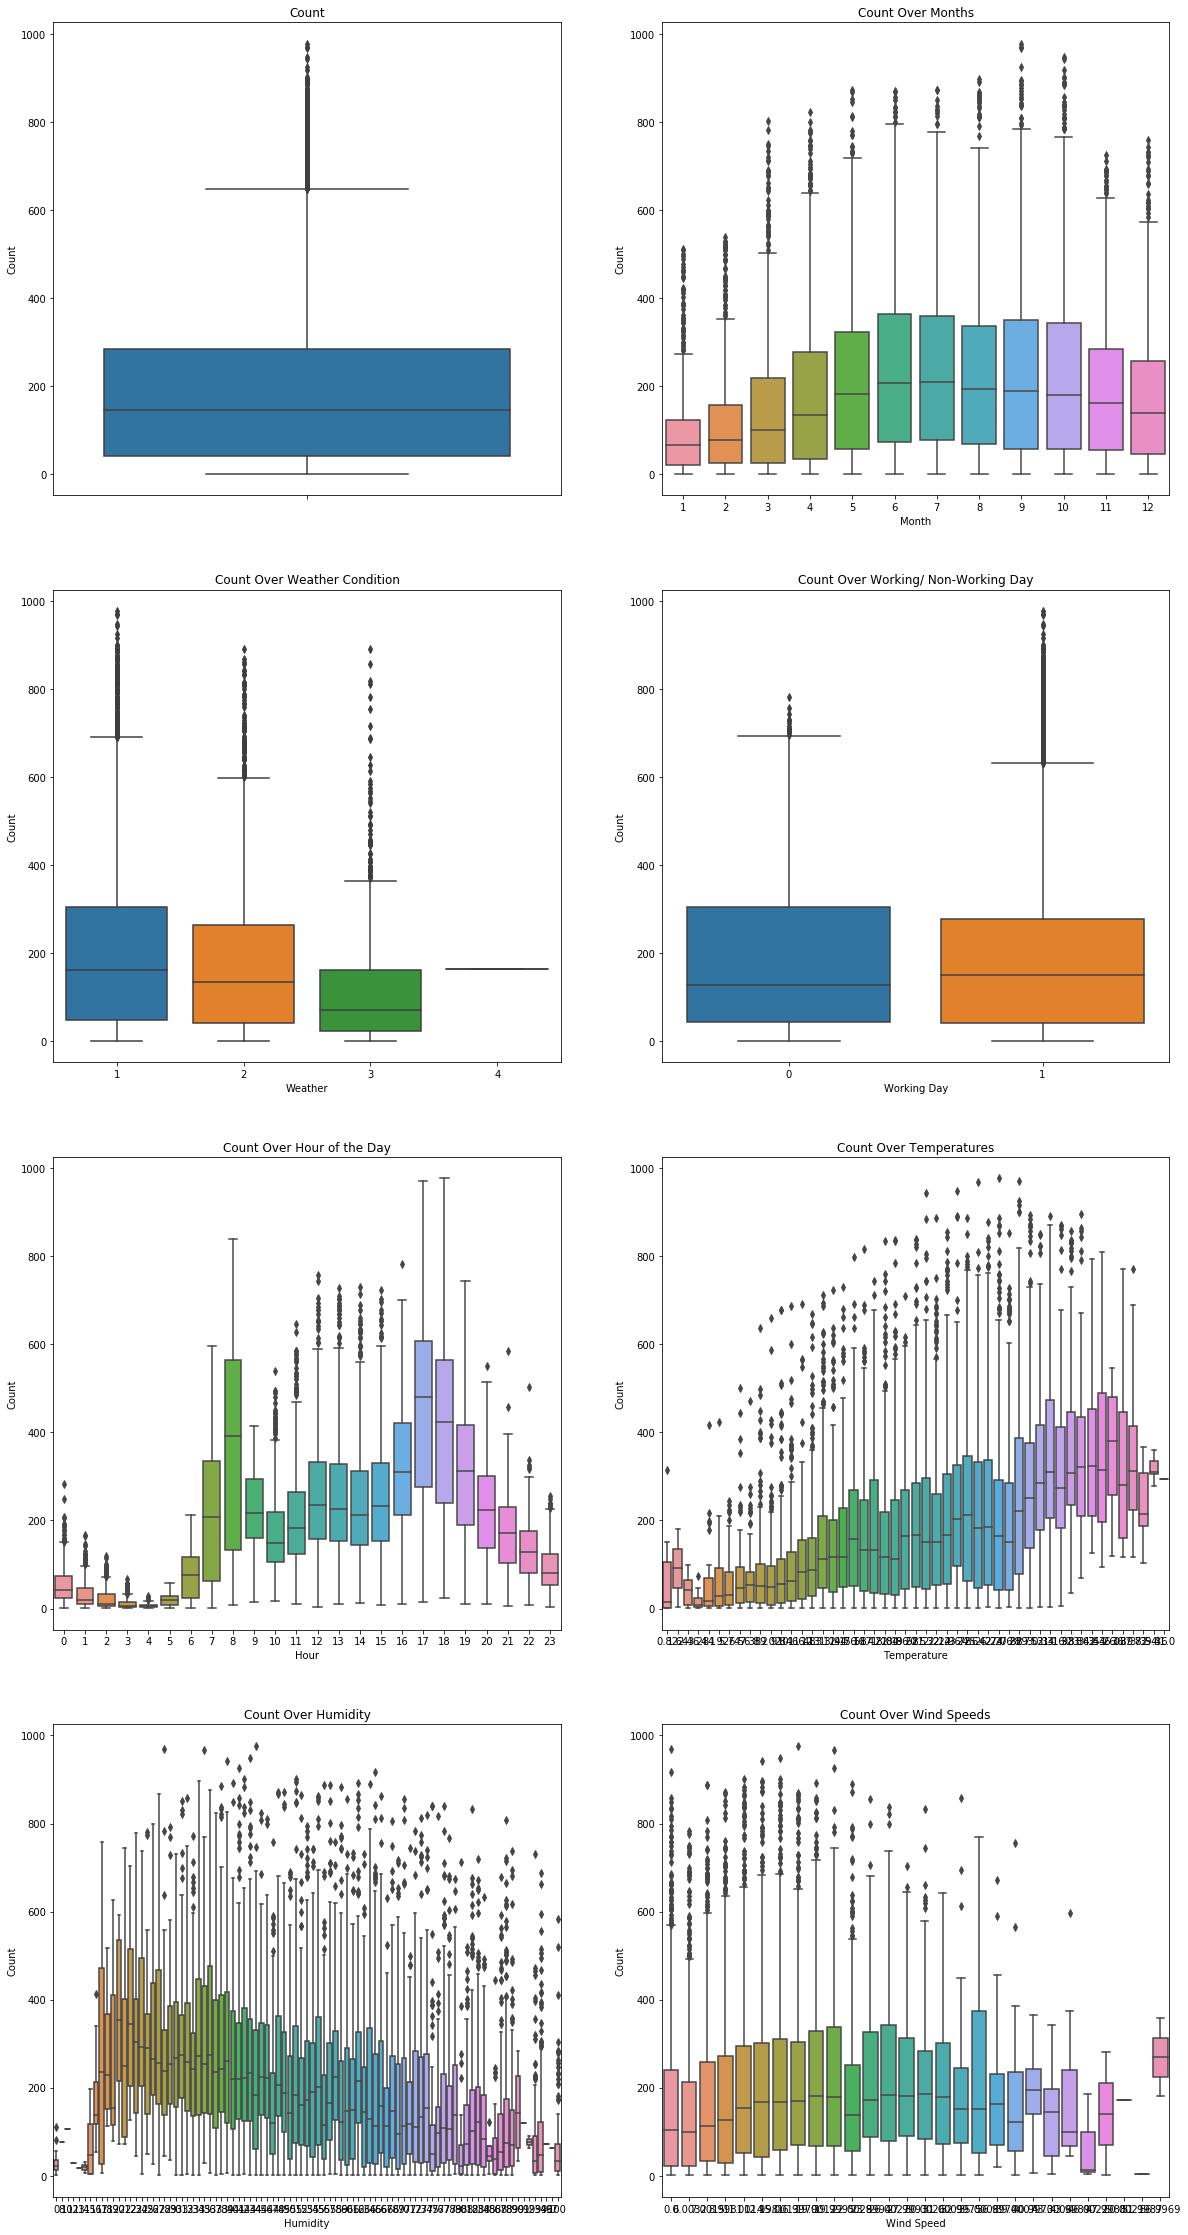

In [28]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 40))
sn.boxplot(data=train_data, y = 'count', orient='v', ax=ax[0][0])
ax[0][0].set(ylabel= 'Count', title = 'Count')
sn.boxplot(data=train_data, y = 'count', x = 'month', orient='v', ax=ax[0][1])
ax[0][1].set(xlabel='Month', ylabel= 'Count', title = 'Count Over Months')
sn.boxplot(data=train_data, y = 'count', x = 'weather', orient='v', ax=ax[1][0])
ax[1][0].set(xlabel='Weather', ylabel= 'Count', title = 'Count Over Weather Condition')
sn.boxplot(data=train_data, y = 'count', x = 'workingday', orient='v', ax=ax[1][1])
ax[1][1].set(xlabel='Working Day', ylabel= 'Count', title = 'Count Over Working/ Non-Working Day')
sn.boxplot(data=train_data, y = 'count', x = 'hour', orient='v', ax=ax[2][0])
ax[2][0].set(xlabel='Hour', ylabel= 'Count', title = 'Count Over Hour of the Day')
sn.boxplot(data=train_data, y = 'count', x = 'temp', orient='v', ax=ax[2][1])
ax[2][1].set(xlabel='Temperature', ylabel= 'Count', title = 'Count Over Temperatures')
sn.boxplot(data=train_data, y = 'count', x = 'humidity', orient='v', ax=ax[3][0])
ax[3][0].set(xlabel='Humidity', ylabel= 'Count', title = 'Count Over Humidity')
sn.boxplot(data=train_data, y = 'count', x = 'windspeed', orient='v', ax=ax[3][1])
ax[3][1].set(xlabel='Wind Speed', ylabel= 'Count', title = 'Count Over Wind Speeds')